In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from MC_cerrada import *
from funciones_redes import *
import joblib

In [2]:
NUM_ASIAN_DATES = 21 
initial_maturity = 5
num_assets = 3
risk_free_rate = 0.01
num_sims = 10000
S_0 = np.array([1,1,1])
correl_matrix = np.array([
    [1, 0.275125, 0.329366],
    [0.275125, 1, 0.381295],
    [0.329366, 0.381295, 1]
])
vols_array = np.array([0.29,0.38,0.33]).reshape(-1,1)
init_time_array = np.linspace(0, initial_maturity, NUM_ASIAN_DATES)

final_model = GRUModel(input_dim=num_assets, hidden_dim=64, output_dim=1)
final_model.load_state_dict(torch.load('modelos/model_run_8.pt'))
final_model.eval()

scaler = joblib.load('scaler_entrenado.gz')

In [3]:
payoff_mc_list = []
payoff_rnn_list = []


for i in np.arange(1,20):
    
    random.seed(77)
    np.random.seed(77) 
    
    # A. Método MonteCarlo (MC)
    rets, payoff_mc, premium_mc = MonteCarlo(
        initial_maturity=initial_maturity, S_0=S_0, num_sims=num_sims, 
        num_assets=num_assets, num_asian_dates=NUM_ASIAN_DATES, 
        value_date_index=i, correl_matrix=correl_matrix, 
        risk_free_rate=risk_free_rate, vols=vols_array
    )

    payoff_mc_list.append(np.mean(payoff_mc))

    # B. Método Red Neuronal (GRU)
    n_sims_loop, n_pasos, n_features = rets.shape
    rets_reshaped = rets.reshape(-1, n_features)
    rets_scaled_reshaped = scaler.transform(rets_reshaped) 
    rets_scaled = rets_scaled_reshaped.reshape(n_sims_loop, n_pasos, n_features)

    rets_tensor = torch.tensor(rets_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        payoff_pred_rnn_tensor = final_model(rets_tensor)
        
    payoff_pred_np = payoff_pred_rnn_tensor.numpy()

    payoff_rnn = np.mean(payoff_pred_np)
    payoff_rnn_list.append(payoff_rnn)

In [4]:
pasos_a_evaluar = np.arange(1, NUM_ASIAN_DATES-1)

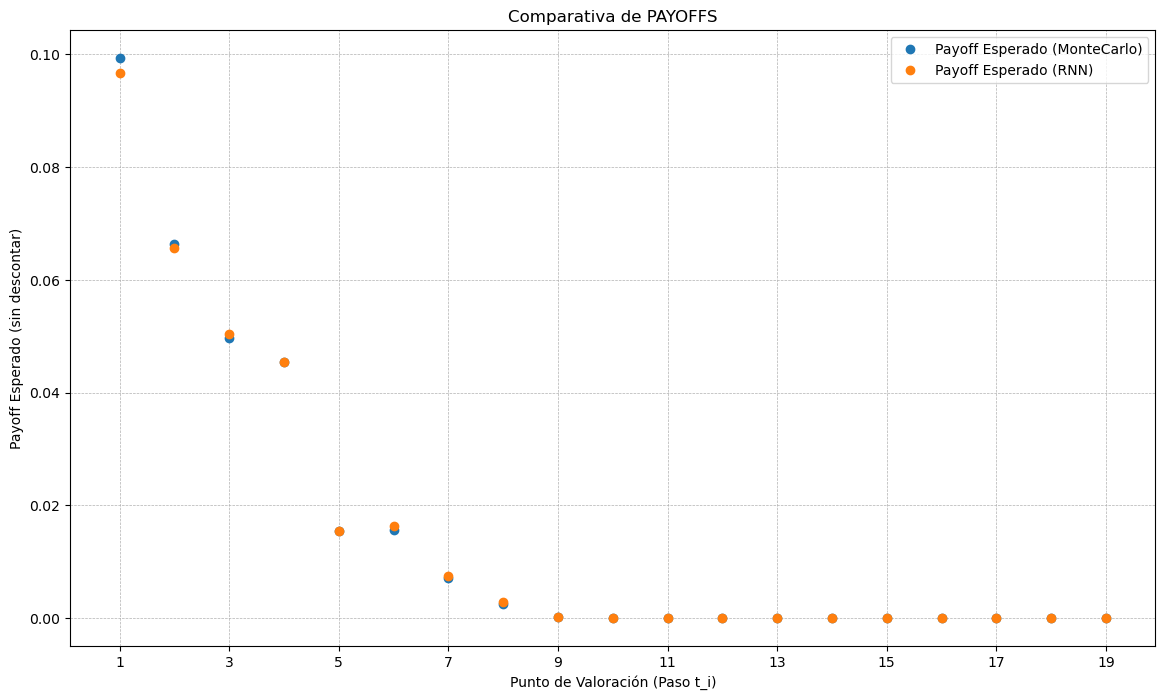

In [5]:
plt.figure(figsize=(14, 8))
plt.plot(pasos_a_evaluar, payoff_mc_list, label='Payoff Esperado (MonteCarlo)', marker='o', linestyle='none')
plt.plot(pasos_a_evaluar, payoff_rnn_list, label='Payoff Esperado (RNN)', marker='o', linestyle='none') 
plt.xlabel('Punto de Valoración (Paso t_i)')
plt.ylabel('Payoff Esperado (sin descontar)')
plt.title(f'Comparativa de PAYOFFS')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(pasos_a_evaluar[::2])
plt.savefig('graficos/comparativa_payoffs.png')
plt.show()

In [6]:
premium_mc_list = []
premium_analytic_list = []
premium_rnn_list = []

for i in np.arange(1,20):
    
    random.seed(77)
    np.random.seed(77) 
    
    # A. Método MonteCarlo
    simu, payoff, premium = MonteCarlo(
        initial_maturity=initial_maturity, S_0=S_0, num_sims=num_sims, 
        num_assets=num_assets, num_asian_dates=NUM_ASIAN_DATES, 
        value_date_index=i, correl_matrix=correl_matrix, 
        risk_free_rate=risk_free_rate, vols=vols_array
    )
    premium_mc_list.append(premium)

    # B. Fórmula cerrada
    S_0_b = np.ones((num_sims, 1, 3))
    S_T_prices = np.concatenate((S_0_b, simu), axis=1)
    price_history_path_0 = S_T_prices[0, :, :].T
    
    analytic = BasketGeomAsian(
        num_asian_dates=NUM_ASIAN_DATES, value_date_index=i, 
        risk_free_rate=risk_free_rate, num_assets=num_assets, 
        assets_vol=vols_array, assets_correl=correl_matrix, 
        initial_maturity=initial_maturity, 
        price_history=price_history_path_0, IsCall=True
    )
    premium_analytic_list.append(analytic)
    
    # C. Método Red Neuronal (RNN)
    n_sims_loop, n_pasos, n_features = simu.shape
    rets_reshaped = simu.reshape(-1, n_features)
    rets_scaled_reshaped = scaler.transform(rets_reshaped) 
    rets_scaled = rets_scaled_reshaped.reshape(n_sims_loop, n_pasos, n_features)
    
    rets_tensor = torch.tensor(rets_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        payoff_pred_rnn_tensor = final_model(rets_tensor)
    payoff_pred_np = payoff_pred_rnn_tensor.numpy()
    
    tiempo_restante_i = initial_maturity - init_time_array[i]
    factor_descuento_i = np.exp(-risk_free_rate * tiempo_restante_i)
    prima_rnn = np.mean(payoff_pred_np * factor_descuento_i)
    premium_rnn_list.append(prima_rnn)

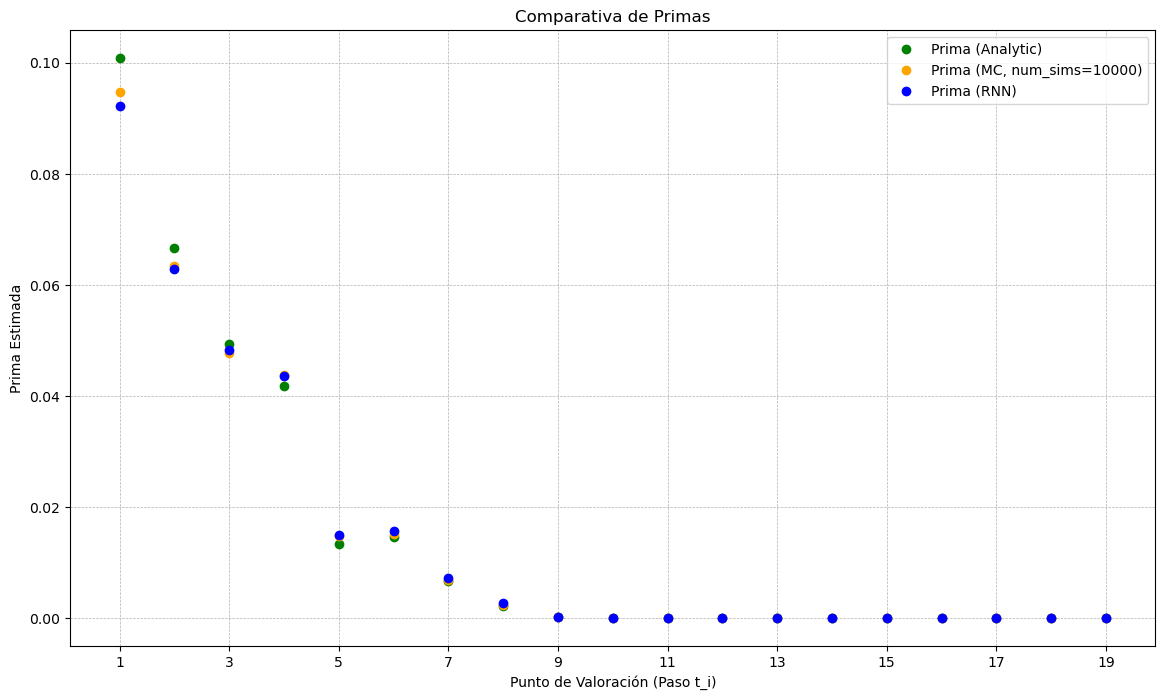

In [7]:
plt.figure(figsize=(14, 8))
plt.plot(pasos_a_evaluar, premium_analytic_list, "o", color='green', label='Prima (Analytic)')
plt.plot(pasos_a_evaluar, premium_mc_list, "o", color='orange', label=f'Prima (MC, num_sims={num_sims})')
plt.plot(pasos_a_evaluar, premium_rnn_list, "o", color='blue', label='Prima (RNN)')
plt.legend()
plt.title(f"Comparativa de Primas")
plt.xlabel('Punto de Valoración (Paso t_i)')
plt.ylabel('Prima Estimada')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(pasos_a_evaluar[::2])
plt.savefig('graficos/comparativa_primas.png')
plt.show()